## Label Empatica-E4 EDA data for training a NN
#### This notebook is based heavily on the work from *Taylor, S., Jaques, N., Chen, W., Fedor, S., Sano, A., & Picard, R. Automatic identification of artifacts in electrodermal activity data. In Engineering in Medicine and Biology Conference. 2015*

In [ ]:
import pandas as pd
import numpy as np
import scipy.signal as scisig
import os

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(15, 5))

In [ ]:
def loadData_E4(filepath):

    # Load EDA data and filter using a low-pass butterworth filter (cutoff:1hz, fs:8hz, order:6)
    #
    eda_data = _loadSingleFile_E4(os.path.join(filepath,'EDA.csv'), ["EDA"], 4, "250L")
    eda_data['filtered_eda'] =  butter_lowpass_filter(eda_data['EDA'], 1.0, 8, 6)

#     return eda_data

    # Load ACC data and scale the accelometer to +-2g
    #
    acc_data = _loadSingleFile_E4(os.path.join(filepath,'ACC.csv'),["AccelX","AccelY","AccelZ"],32,"31250U")
    acc_data[["AccelX","AccelY","AccelZ"]] = acc_data[["AccelX","AccelY","AccelZ"]]/64.0

#    return acc_data
    
    # Load Temperature data
    temperature_data = _loadSingleFile_E4(os.path.join(filepath,'TEMP.csv'),["Temp"],4,"250L")
    
    data = eda_data.join(acc_data, how='outer')
    data = data.join(temperature_data, how='outer')

    return data


In [ ]:
def _loadSingleFile_E4(filepath, list_of_columns, expected_sample_rate, freq):
    # Load data
    data = pd.read_csv(filepath)
#     data.reset_index(inplace=True)
    
    # Get the startTime and sample rate
    #
    startTime = pd.to_datetime(float(data.columns.values[0]),unit="s")
    sampleRate = float(data.iloc[0][0])
    print("sample rate: " + str(sampleRate))
    data = data[data.index!=0]
    data.index = data.index-1
    
    # Reset the data frame assuming expected_sample_rate
    #
    data.columns = list_of_columns
    if sampleRate != expected_sample_rate:
        print('ERROR, NOT SAMPLED AT {0}HZ. PROBLEMS WILL OCCUR\n'.format(expected_sample_rate))
    #data.index = pd.DatetimeIndex(start=startTime,periods = len(data),freq=freq)

    # Make sure data has a sample rate of 8Hz
    #
    data = interpolateDataTo8Hz(data, sampleRate, startTime)
    
    return data

In [ ]:
def interpolateDataTo8Hz(data, sample_rate, startTime):
        
    if sample_rate<8:
        # Upsample by linear interpolation
        if sample_rate==2:
            data.index = pd.DatetimeIndex(start=startTime, periods = len(data), freq='500L')
        elif sample_rate==4:
            data.index = pd.DatetimeIndex(start=startTime, periods = len(data), freq='250L')
       
        data = data.resample("125L").mean()
    else:
        if sample_rate>8:
            # Assign datetime index based on 32 Hz sampling rate (assumes acceleration, different for others.)
            #
            # data.index = pd.DatetimeIndex(start=startTime, periods=len(temp), freq='31250U') 
            # data = data.resample("125L").asfreq() # resample at 8Hz 
            
            # Downsample
            idx_range = range(0,len(data))
            print 
            data = data.iloc[idx_range[0::int(sample_rate/8)]]
        # Set the index to be 8Hz
        data.index = pd.DatetimeIndex(start=startTime,periods = len(data),freq='125L')
        
    # Interpolate all empty values
    data = interpolateEmptyValues(data)
    return data


def interpolateEmptyValues(data):
    cols = data.columns.values
    for c in cols:
        data[c] = data[c].interpolate()

    return data

In [ ]:
# TODO: Use wavelets instead butterworth low-pass
#

def butter_lowpass(cutoff, fs, order=5):
    # Filtering Helper functions
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
    
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    # Filtering Helper functions
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scisig.lfilter(b, a, data)
    
    return y

## Load in EDA data and perform basic processing (downsample, upsample, interpolate).

In [ ]:
#filepath = "/home/jstaley/Desktop/Projects/PATRONUS-20180215T110638Z-001/Data/VR/Volunteer6/Date-20180528/Session-1/Empatica-E4/Spiders"
filepath = "/home/jstaley/Desktop/Projects/PATRONUS-20180215T110638Z-001/Data/VR/Volunteer6/Date-20180528/Session-1/Empatica-E4/Plank"
#filepath = input("\tPath to E4 directory: ")
#filepath_confirm = os.path.join(filepath,"EDA.csv")
data = loadData_E4(filepath)

In [ ]:
data

## Perform peak detection.

In [ ]:
# Frequency that signals were upsampled or downsampled to.
#
SAMPLE_RATE = 8

def findPeaks(data, offset, start_WT, end_WT, thres=0, sampleRate=SAMPLE_RATE):
    '''
        This function finds the peaks of an EDA signal and returns basic properties.
        Also, peak_end is assumed to be no later than the start of the next peak. (Is this okay??)

        ********* INPUTS **********
        data:        DataFrame with EDA as one of the columns and indexed by a datetimeIndex
        offset:      the number of rising samples and falling samples after a peak needed to be counted as a peak
        start_WT:    maximum number of seconds before the apex of a peak that is the "start" of the peak
        end_WT:      maximum number of seconds after the apex of a peak that is the "rec.t/2" of the peak, 50% of amp
        thres:       the minimum uS change required to register as a peak, defaults as 0 (i.e. all peaks count)
        sampleRate:  number of samples per second, default=8

        ********* OUTPUTS **********
        peaks:               list of binary, 1 if apex of SCR
        peak_start:          list of binary, 1 if start of SCR
        peak_start_times:    list of strings, if this index is the apex of an SCR, it contains datetime of start of peak
        peak_end:            list of binary, 1 if rec.t/2 of SCR
        peak_end_times:      list of strings, if this index is the apex of an SCR, it contains datetime of rec.t/2
        amplitude:           list of floats,  value of EDA at apex - value of EDA at start
        max_deriv:           list of floats, max derivative within 1 second of apex of SCR

    '''
    EDA_deriv = data['filtered_eda'][1:].as_matrix() - data['filtered_eda'][:-1].as_matrix()
    peaks = np.zeros(len(EDA_deriv))
    peak_sign = np.sign(EDA_deriv)
    for i in range(int(offset), int(len(EDA_deriv) - offset)):
        if peak_sign[i] == 1 and peak_sign[i + 1] < 1:
            peaks[i] = 1
            for j in range(1, int(offset)):
                if peak_sign[i - j] < 1 or peak_sign[i + j] > -1:
                    #if peak_sign[i-j]==-1 or peak_sign[i+j]==1:
                    peaks[i] = 0
                    break

    # Finding start of peaks
    peak_start = np.zeros(len(EDA_deriv))
    peak_start_times = [''] * len(data)
    max_deriv = np.zeros(len(data))
    rise_time = np.zeros(len(data))

    for i in range(0, len(peaks)):
        if peaks[i] == 1:
            temp_start = max(0, i - sampleRate)
            max_deriv[i] = max(EDA_deriv[temp_start:i])
            start_deriv = .01 * max_deriv[i]

            found = False
            find_start = i
            # has to peak within start_WT seconds
            while found == False and find_start > (i - start_WT * sampleRate):
                if EDA_deriv[find_start] < start_deriv:
                    found = True
                    peak_start[find_start] = 1
                    peak_start_times[i] = data.index[find_start]
                    rise_time[i] = get_seconds_and_microseconds(data.index[i] - pd.to_datetime(peak_start_times[i]))

                find_start = find_start - 1

            # If we didn't find a start
            if found == False:
                peak_start[i - start_WT * sampleRate] = 1
                peak_start_times[i] = data.index[i - start_WT * sampleRate]
                rise_time[i] = start_WT

            # Check if amplitude is too small
            if thres > 0 and (data['EDA'].iloc[i] - data['EDA'][peak_start_times[i]]) < thres:
                peaks[i] = 0
                peak_start[i] = 0
                peak_start_times[i] = ''
                max_deriv[i] = 0
                rise_time[i] = 0

    # Finding the end of the peak, amplitude of peak
    peak_end = np.zeros(len(data))
    peak_end_times = [''] * len(data)
    amplitude = np.zeros(len(data))
    decay_time = np.zeros(len(data))
    half_rise = [''] * len(data)
    SCR_width = np.zeros(len(data))

    for i in range(0, len(peaks)):
        if peaks[i] == 1:
            peak_amp = data['EDA'].iloc[i]
            start_amp = data['EDA'][peak_start_times[i]]
            amplitude[i] = peak_amp - start_amp

            half_amp = amplitude[i] * .5 + start_amp

            found = False
            find_end = i
            # has to decay within end_WT seconds
            while found == False and find_end < (i + end_WT * sampleRate) and find_end < len(peaks):
                if data['EDA'].iloc[find_end] < half_amp:
                    found = True
                    peak_end[find_end] = 1
                    peak_end_times[i] = data.index[find_end]
                    decay_time[i] = get_seconds_and_microseconds(pd.to_datetime(peak_end_times[i]) - data.index[i])

                    # Find width
                    find_rise = i
                    found_rise = False
                    while found_rise == False:
                        if data['EDA'].iloc[find_rise] < half_amp:
                            found_rise = True
                            half_rise[i] = data.index[find_rise]
                            SCR_width[i] = get_seconds_and_microseconds(pd.to_datetime(peak_end_times[i]) - data.index[find_rise])
                        find_rise = find_rise - 1

                elif peak_start[find_end] == 1:
                    found = True
                    peak_end[find_end] = 1
                    peak_end_times[i] = data.index[find_end]
                find_end = find_end + 1

            # If we didn't find an end
            if found == False:
                min_index = np.argmin(data['EDA'].iloc[i:(i + end_WT * sampleRate)].tolist())
                peak_end[i + min_index] = 1
                peak_end_times[i] = data.index[i + min_index]

    peaks = np.concatenate((peaks, np.array([0])))
    peak_start = np.concatenate((peak_start, np.array([0])))
    max_deriv = max_deriv * sampleRate  # now in change in amplitude over change in time form (uS/second)

    return peaks, peak_start, peak_start_times, peak_end, peak_end_times, amplitude, max_deriv, rise_time, decay_time, SCR_width, half_rise



def get_seconds_and_microseconds(pandas_time):
    return pandas_time.seconds + pandas_time.microseconds * 1e-6


In [ ]:
def calcPeakFeatures(data,outfile,offset,thresh,start_WT,end_WT):
    returnedPeakData = findPeaks(data, offset*SAMPLE_RATE, start_WT, end_WT, thresh, SAMPLE_RATE)
    data['peaks'] = returnedPeakData[0]
    data['peak_start'] = returnedPeakData[1]
    data['peak_end'] = returnedPeakData[3]

    data['peak_start_times'] = returnedPeakData[2]
    data['peak_end_times'] = returnedPeakData[4]
    data['half_rise'] = returnedPeakData[10]
    # Note: If an SCR doesn't decrease to 50% of amplitude, then the peak_end = min(the next peak's start, 15 seconds after peak)
    data['amp'] = returnedPeakData[5]
    data['max_deriv'] = returnedPeakData[6]
    data['rise_time'] = returnedPeakData[7]
    data['decay_time'] = returnedPeakData[8]
    data['SCR_width'] = returnedPeakData[9]

    featureData = data[data.peaks==1][['EDA','rise_time','max_deriv','amp','decay_time','SCR_width']]

    # Replace 0s with NaN, this is where the 50% of the peak was not found, too close to the next peak
    featureData[['SCR_width','decay_time']]=featureData[['SCR_width','decay_time']].replace(0, np.nan)
    featureData['AUC']=featureData['amp']*featureData['SCR_width']

    featureData.to_csv(outfile)

    return data

In [ ]:
# draws a graph of the data with the peaks marked on it
# assumes that 'data' dataframe already contains the 'peaks' column
#
def plotPeaks(data, x_seconds, sampleRate = SAMPLE_RATE):
    if x_seconds:
        time_m = np.arange(0,len(data))/float(sampleRate)
    else:
        time_m = np.arange(0,len(data))/(sampleRate*60.)

    data_min = min(data['EDA'])
    data_max = max(data['EDA'])

    #Plot the data with the Peaks marked
    plt.figure(1,figsize=(20, 5))
    peak_height = data_max * 1.15
    data['peaks_plot'] = data['peaks'] * peak_height
    plt.plot(time_m,data['peaks_plot'],'#4DBD33')
    #plt.plot(time_m,data['EDA'])
    plt.plot(time_m,data['filtered_eda'])
    plt.xlim([0,time_m[-1]])
    y_min = min(0, data_min) - (data_max - data_min) * 0.1
    plt.ylim([min(y_min, data_min),peak_height])
    plt.title('EDA with Peaks marked')
    plt.ylabel('$\mu$S')
    if x_seconds:
        plt.xlabel('Time (s)')
    else:
        plt.xlabel('Time (min)')

    plt.show()

In [ ]:
def chooseValueOrDefault(str_input, default):
    if str_input == "":
        return default
    else:
        return float(str_input)


print("Please choose settings for the peak detection algorithm. For default values press return")
thresh_str = input('\tMinimum peak amplitude (default = .02):')
thresh = chooseValueOrDefault(thresh_str,.02)
offset_str = input('\tOffset (default = 1): ')
offset = chooseValueOrDefault(offset_str,1)
start_WT_str = input('\tMax rise time (s) (default = 4): ')
start_WT = chooseValueOrDefault(start_WT_str,4)
end_WT_str = input('\tMax decay time (s) (default = 4): ')
end_WT = chooseValueOrDefault(end_WT_str,4)

# Where the output from the peak detection is saved.
#
fullOutputPath = os.path.join(filepath,'peak_processing.csv')

# Perform the peak detection.
#
peakData = calcPeakFeatures(data, fullOutputPath, offset, thresh, start_WT, end_WT)

# Plotting the data
#
plot_ans = input("Do you want to plot the detected peaks? (y/n): ")
if 'y' in plot_ans:
    secs_ans = input("Would you like the x-axis to be in seconds or minutes? (s/m): ")
    if 's' in secs_ans:
        x_seconds=True
    else:
        x_seconds=False
    plotPeaks(peakData,x_seconds)

In [ ]:
data

In [ ]:
# Find the indices of peaks so that markers can be placed on the EDA plot.
#
marker_indices = [i for i,x in enumerate(data['peaks'].tolist()) if x == 1.0]

plt.figure(figsize=(18,5))

# Plot the EDA signal, with peaks marked.
#
plt.plot(data.filtered_eda, color='xkcd:azure', linewidth=3.0, label='valid EDA peaks', 
         markeredgecolor='orange', markerfacecolor='orange', marker='*', 
         markersize=12, markevery=marker_indices)
# Plot the beginning of a peak.
#
plt.plot(data.peak_start*data.filtered_eda, '--g', alpha=0.5)

# Plot the end of a peak.
#
plt.plot(data.peak_end*data.filtered_eda, '--r', alpha=0.5)


plt.legend()
plt.show()

In [ ]:
peakData

## Extract just the valid peaks.

In [ ]:
# List that will hold timeseries data of every valid EDA peak found from the volunteer, for a given
# VR environment.
#
all_peaks = []

# Create a dataframe that only is comprised of detected peaks and associated values.
#
temp = peakData[data['peaks'] == 1.0]

# Default fig size.
#
plt.figure(figsize=(18,5))


for i,idx_val in enumerate(temp.index):
    start = temp.loc[idx_val]['peak_start_times']
    end = temp.loc[idx_val]['peak_end_times']
#     print(start)
#     print(end)
#     print(end-start)
#     print(" ")
    
    # Retreive the valid EDA peak data between the calculated time window.
    #
    valid_eda_peak = peakData.between_time(start.time(), end.time())
    peak = valid_eda_peak.filtered_eda
    
    # Store all the valid peaks for this volunteer and in this VR environment.
    #
    all_peaks.append(peak.values)

    plt.plot(peak)
    
# peakData.loc[data['peaks'] == 1.0]

In [ ]:

def normalize_peaks(all_peaks, val_range='norm_uniform'):
    # Create a normalized (i.e. 0-1) version of 'all_peaks' 
    print("Peaks detected: " + str(len(all_peaks)))

    # Get the maximmum EDA response from the entire session.
    #
    max_peak_val = max([max(sublist) for sublist in all_peaks])

    # Holds the resulting scaled peak values.
    #
    scaled_peaks = []

    # Default fig size.
    #
    plt.figure(figsize=(15,5))


    for peak in all_peaks:
        p_max = max(peak)
        p_min = min(peak)

        # Uniformly normalized (i.e. 0-1) peaks.
        #
        if val_range == 'norm_uniform':
            normed_peak = (peak-p_min)/(p_max-p_min)

        elif val_range == 'norm_max':
            normed_peak = (peak-p_min)/(max_peak_val-p_min)
        else:
            normed_peak = (peak-p_min)


        scaled_peaks.append(normed_peak)
        plt.plot(normed_peak)

    
    return scaled_peaks

    

In [ ]:
scaled_peaks = normalize_peaks(all_peaks, val_range='norm_uniform')

## Zero-pad all peaks to have the same length.
#### Necessary for training the neural network.

In [ ]:
def zero_pad_peaks(peaks, final_length=128):
    '''final_length is the resulting length after zero-padding the begging of the peak data.'''
    
    padded_peaks = []
    
    # Zero-pad the beginning of all detected peaks so that they are all the same length
    # in data points.
    #
    for peak in peaks:
        padded = np.pad(peak, (final_length-len(peak),0), 'constant')
        #plt.plot(padded_peak)
        padded_peaks.append(padded)
        
    return padded_peaks


In [ ]:
padded_peaks = zero_pad_peaks(scaled_peaks, final_length=128)
for peak in padded_peaks:
    plt.plot(peak)

## Begin wavelet analysis and feature extraction.

In [ ]:
# import imp
import pywt

In [ ]:
def getWaveletData(data):
    '''
    This function computes the wavelet coefficients

    INPUT:
        data:  DataFrame, index is a list of timestamps at 8Hz, columns include EDA, filtered_eda

    OUTPUT:
        wave1Second:    DateFrame, index is a list of timestamps at 1Hz, 
                        columns include OneSecond_feature1, OneSecond_feature2, OneSecond_feature3 
        waveHalfSecond: DateFrame, index is a list of timestamps at 2Hz, 
                        columns include HalfSecond_feature1, HalfSecond_feature2 
    '''
    startTime = data.index[0]

    # Create wavelet dataframes
    #
    oneSecond = pd.DatetimeIndex(start=startTime, periods=len(data), freq='1s')
    halfSecond = pd.DatetimeIndex(start=startTime, periods=len(data), freq='500L')

    # Compute wavelets
    #
    cA_n, cD_3, cD_2, cD_1 = pywt.wavedec(data['EDA'], 'Haar', level=3) #3 = 1Hz, 2 = 2Hz, 1=4Hz
    
    # Wavelet 1 second window
    #
    N = int(len(data)/8)
    coeff1 = np.max(abs(np.reshape(cD_1[0:4*N], (N,4))), axis=1)
    coeff2 = np.max(abs(np.reshape(cD_2[0:2*N], (N,2))), axis=1)
    coeff3 = abs(cD_3[0:N])
    wave1Second = pd.DataFrame({'OneSecond_feature1': coeff1,
                                'OneSecond_feature2': coeff2,
                                'OneSecond_feature3': coeff3})
    wave1Second.index = oneSecond[:len(wave1Second)]
    
    # Wavelet Half second window
    #
    N = int(np.floor((len(data)/8.0)*2))
    coeff1 = np.max(abs(np.reshape(cD_1[0:2*N], (N,2))), axis=1)
    coeff2 = abs(cD_2[0:N])
    waveHalfSecond = pd.DataFrame({'HalfSecond_feature1': coeff1,
                                   'HalfSecond_feature2': coeff2})
    waveHalfSecond.index = halfSecond[:len(waveHalfSecond)]

    return wave1Second, waveHalfSecond


In [ ]:
def computeWaveletFeatures(waveDF):
    maxList = waveDF.max().tolist()
    meanList = waveDF.mean().tolist()
    stdList = waveDF.std().tolist()
    medianList = waveDF.median().tolist()
    aboveZeroList = (waveDF[waveDF>0]).count().tolist()

    return maxList,meanList,stdList,medianList,aboveZeroList

def getWavelet(wave1Second,waveHalfSecond):
    max_1,mean_1,std_1,median_1,aboveZero_1 = computeWaveletFeatures(wave1Second)
    max_H,mean_H,std_H,median_H,aboveZero_H = computeWaveletFeatures(waveHalfSecond)
    
    return max_1,mean_1,std_1,median_1,aboveZero_1,max_H,mean_H,std_H,median_H,aboveZero_H

In [ ]:
def getDerivatives(eda):
    deriv = (eda[1:-1] + eda[2:])/ 2. - (eda[1:-1] + eda[:-2])/ 2.
    second_deriv = eda[2:] - 2*eda[1:-1] + eda[:-2]
    
    return deriv,second_deriv

def get3MaxDerivatives(eda,num_max=3):
    deriv, second_deriv = getDerivatives(eda)
    d = copy.deepcopy(deriv)
    d2 = copy.deepcopy(second_deriv)
    max_indices = []
    for i in range(num_max):
        maxd_idx = np.nanargmax(abs(d))
        max_indices.append(maxd_idx)
        d[maxd_idx] = 0
        max2d_idx = np.nanargmax(abs(d2))
        max_indices.append(max2d_idx)
        d2[max2d_idx] = 0
    
    return max_indices, abs(deriv), abs(second_deriv)


In [ ]:
def getDerivStats(eda):
    deriv, second_deriv = getDerivatives(eda)
    maxd = max(deriv)
    mind = min(deriv)
    maxabsd = max(abs(deriv))
    avgabsd = np.mean(abs(deriv))
    max2d = max(second_deriv)
    min2d = min(second_deriv)
    maxabs2d = max(abs(second_deriv))
    avgabs2d = np.mean(abs(second_deriv))
    
    return maxd, mind, maxabsd, avgabsd, max2d, min2d, maxabs2d, avgabs2d

            
def getStats(data):
    eda = data['EDA'].as_matrix()
    filt = data['filtered_eda'].as_matrix()
    maxd,mind,maxabsd,avgabsd,max2d,min2d,maxabs2d,avgabs2d = getDerivStats(eda)
    maxd_f,mind_f,maxabsd_f,avgabsd_f,max2d_f,min2d_f,maxabs2d_f,avgabs2d_f = getDerivStats(filt)
    amp = np.mean(eda)
    amp_f = np.mean(filt)
    
    return amp, maxd, mind, maxabsd, avgabsd, max2d, min2d, maxabs2d, avgabs2d, amp_f, maxd_f, mind_f, maxabsd_f, avgabsd_f, max2d_f, min2d_f, maxabs2d_f, avgabs2d_f



In [ ]:
def getFeatures(data,w1,wH):
    # Get DerivStats
    amp,maxd,mind,maxabsd,avgabsd,max2d,min2d,maxabs2d,avgabs2d,amp_f,maxd_f,mind_f,maxabsd_f,avgabsd_f,max2d_f,min2d_f,maxabs2d_f,avgabs2d_f = getStats(data)
    statFeat = np.hstack([amp,maxd,mind,maxabsd,avgabsd,max2d,min2d,maxabs2d,avgabs2d,amp_f,maxd_f,mind_f,maxabsd_f,avgabsd_f,max2d_f,min2d_f,maxabs2d_f,avgabs2d_f])

    # Get Wavelet Features
    max_1,mean_1,std_1,median_1,aboveZero_1,max_H,mean_H,std_H,median_H,aboveZero_H = getWavelet(w1,wH)
    waveletFeat = np.hstack([max_1,mean_1,std_1,median_1,aboveZero_1,max_H,mean_H,std_H,median_H,aboveZero_H])

    all_feat = np.hstack([statFeat,waveletFeat])
    
    if np.Inf in all_feat:
        print("Inf")
    
    if np.NaN in all_feat:
        print("NaN")

    return list(all_feat)

In [ ]:
def createFeatureDF(data):
    '''
    INPUTS:
        filepath:           string, path to input file  
    OUTPUTS:
        features:           DataFrame, index is a list of timestamps for each 5 seconds, contains all the features
        data:               DataFrame, index is a list of timestamps at 8Hz, columns include AccelZ, AccelY, AccelX,
                            Temp, EDA, filtered_eda
    '''
    # Load data from q sensor
    wave1sec,waveHalf = getWaveletData(data)
    
    # Create 5 second timestamp list
    timestampList = data.index.tolist()[0::40]
    
    # feature names for DataFrame columns
    allFeatureNames = ['raw_amp','raw_maxd','raw_mind','raw_maxabsd','raw_avgabsd','raw_max2d','raw_min2d',
                       'raw_maxabs2d','raw_avgabs2d','filt_amp','filt_maxd','filt_mind','filt_maxabsd',
                       'filt_avgabsd', 'filt_max2d','filt_min2d','filt_maxabs2d','filt_avgabs2d','max_1s_1',
                       'max_1s_2','max_1s_3','mean_1s_1','mean_1s_2','mean_1s_3','std_1s_1', 'std_1s_2',
                       'std_1s_3','median_1s_1','median_1s_2','median_1s_3','aboveZero_1s_1','aboveZero_1s_2',
                       'aboveZero_1s_3','max_Hs_1','max_Hs_2','mean_Hs_1','mean_Hs_2','std_Hs_1',
                       'std_Hs_2','median_Hs_1','median_Hs_2','aboveZero_Hs_1','aboveZero_Hs_2']

    # Initialize Feature Data Frame
    features = pd.DataFrame(np.zeros((len(timestampList),len(allFeatureNames))),
                            columns=allFeatureNames,
                            index=timestampList)
    
    # Compute features for each 5 second epoch
    for i in range(len(features)-1):
        start = features.index[i]
        end = features.index[i+1]
        this_data = data[start:end]
        this_w1 = wave1sec[start:end]
        this_w2 = waveHalf[start:end]
        features.iloc[i] = getFeatures(this_data,this_w1,this_w2)
        
        
    return features

In [ ]:
features = createFeatureDF(data)

In [ ]:
print(features.columns.values)
#plt.plot(features.median_1s_3)
#plt.plot(features.mean_Hs_2)
#plt.plot(features.filt_amp[:-1], linewidth=3.0)
plt.plot(data['EDA'])
plt.ylabel('$\mu$S')
#color='xkcd:azure', linewidth=3.0,
#plt.plot(features.filt_maxabsd[:-1])
#plt.plot(features.std_1s_3)
#plt.plot(features.raw_amp[:-1])
#plt.plot(features.max_1s_2)

In [ ]:
# Load data from E4 sensor
#
wave1sec, waveHalf = getWaveletData(data)

In [ ]:
type(wave1sec)

In [ ]:
plt.plot(wave1sec.OneSecond_feature1)
plt.show()
plt.plot(wave1sec.OneSecond_feature2)
plt.show()
plt.plot(wave1sec.OneSecond_feature3)
plt.show()


In [ ]:
# plt.figure(figsize=(14,7))
# plt.plot(data.peaks*data.filtered_eda.max())
# plt.plot(data.filtered_eda)

In [ ]:
# data.index[data['peaks'] == 1.0].tolist()
# data.loc[data['peaks'] == 1.0]

# Test new structure of working with data through 'data_utils'.

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as scisig

import os
import sys
module_path = os.path.abspath(os.path.join('../utilities'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ipynb.fs.full.Data_utils as data_utils

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(15, 5))

In [ ]:
# Dictionary containing all information about all experiments.
#
data_path = '/home/jstaley/Projects/PATRONUS-20180215T110638Z-001/Data/VR/'
container = data_utils.create_data_container(data_path, process_peaks=False)

In [ ]:
segmented_data.keys()

In [ ]:
# segmented_data['Volunteer5']['Spiders']['filtered_eda'].plot()
# eda_peaks = data_utils.extract_valid_EDA_peaks_from_signal(segmented_data['Volunteer5']['Spiders'], plot=True)
# plt.show()

In [11]:
# filepath = "/home/jstaley/Desktop/Projects/PATRONUS-20180215T110638Z-001/Data/VR/Volunteer5/Date-20180515/Session-1/Empatica-E4/Spiders"
filepath = "/home/jstaley/Desktop/Projects/PATRONUS-20180215T110638Z-001/Data/VR/Volunteer6/Date-20180528/Session-1/Empatica-E4/Spiders"
#filepath = input("\tPath to E4 directory: ")
#filepath_confirm = os.path.join(filepath,"EDA.csv")
data = data_utils.load_filter_resample_empatica_data(filepath)

sample rate: 4.0
sample rate: 32.0
sample rate: 4.0


ipynb.fs.full.Data_utils:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
peak_data = data_utils.run_EDA_peak_detection(data, filepath)

In [13]:
peak_data

,EDA,filtered_eda,AccelX,AccelY,AccelZ,Temp,peaks,peak_start,peak_end,peak_start_times,peak_end_times,half_rise,amp,max_deriv,rise_time,decay_time,SCR_width
2018-05-28 12:24:19.000,0.000000,0.000000,0.906250,0.000000,-0.328125,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.125,0.421919,0.000444,0.906250,0.000000,-0.328125,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.250,0.843838,0.004871,0.921875,0.031250,-0.312500,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.375,1.016836,0.025724,0.906250,0.031250,-0.265625,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.500,1.189835,0.087770,0.921875,-0.015625,-0.281250,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.625,1.408832,0.219669,0.906250,0.000000,-0.328125,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.750,1.627830,0.434636,0.921875,0.000000,-0.312500,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:19.875,1.866690,0.716264,0.921875,-0.015625,-0.328125,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:20.000,2.105549,1.023847,0.921875,0.015625,-0.312500,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0
2018-05-28 12:24:20.125,2.258026,1.313906,0.906250,0.000000,-0.328125,34.890,0.0,0.0,0.0,,,,0.000000,0.000000,0.0,0.0,0.0


In [14]:
# Number of detected peaks.
#
peak_data.peaks.sum()

25.0

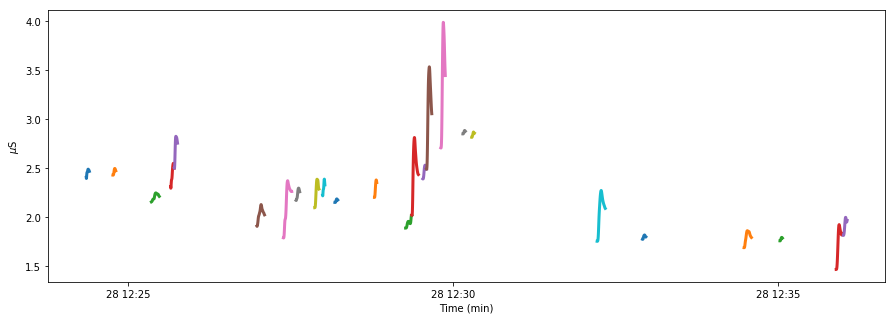

In [15]:
valid_eda_peaks = data_utils.extract_valid_EDA_peaks_from_signal(peak_data, plot=True)

Peaks detected: 25


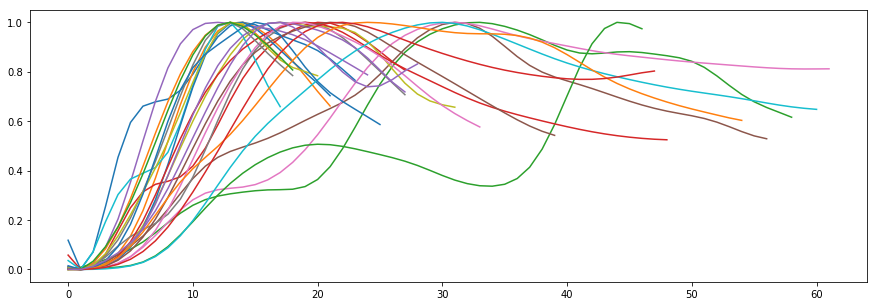

In [16]:
normed_peaks = data_utils.normalize_peaks(valid_eda_peaks, plot=True)

In [ ]:
padded_normed_peaks = data_utils.zero_pad_peaks(normed_peaks)

In [ ]:
padded_normed_peaks.shape

In [ ]:
for peak in padded_normed_peaks:
    plt.plot(peak)

In [ ]:
# Test loading in data, and resample during the loading process.
#
container = data_utils.create_data_container(data_path, resample=True)

## Extract valid peaks from all volunteers, and all 'spider' and 'plank' VR environments.

In [2]:
# Dictionary containing all information about all experiments.
#
data_path = '/home/jstaley/Projects/PATRONUS-20180215T110638Z-001/Data/VR/'
container, segmented_data = data_utils.create_data_container(data_path, process_peaks=True)

TODO:
 -- Add ability to parse left and right hand data, which began in Volunteer number 12+
Resampling data to a common frequency, and performing EDA peak extraction
Volunteer6
---/Date-20180528
---/---Session-1
---/---/---Chillband
---/---/---GF-capture
---/---/---/---Plank
---/---/---/---/---Desktop 2018.05.28 - 14.37.44.06.mp4
---/---/---/---Baseline
---/---/---/---/---Desktop 2018.05.28 - 14.09.59.04.mp4
---/---/---/---Spiders
---/---/---/---/---Desktop 2018.05.28 - 14.23.44.05.mp4
---/---/---Empatica-E4
---/---/---/---Plank
sample rate: 4.0
sample rate: 32.0
sample rate: 4.0


ipynb.fs.full.Data_utils:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
---/---/---/---Baseline
sample rate: 4.0
sample rate: 32.0
sample rate: 4.0
---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
---/---/---/---Spiders
sample rate: 4.0
sample rate: 32.0
sample rate: 4.0
---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
Volunteer3
---/Date-20180510
---/---Session-1
---/---/---Chillband
---/---/---

---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
---/---/---/---Baseline
sample rate: 4.0
sample rate: 32.0
sample rate: 4.0
---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
---/---/---/---Apex
sample rate: 4.0
sample rate: 32.0
sample rate: 4.0
---/---/---/---/---HR.csv
---/---/---/---/---info.txt
---/---/---/---/---tags.csv
---/---/---/---/---TEMP.csv
---/---/---/---/---IBI.csv
---/---/---/---/---EDA.csv
---/---/---/---/---BVP.csv
---/---/---/---/---ACC.csv
---/---/---/---/---peak_processing.csv
Volunteer11
---/Date-20180531
---/---Session-1
---/---/---Chillband
---/---/---GF

In [3]:
print(segmented_data.keys())

dict_keys(['Volunteer2', 'Volunteer9', 'Volunteer7', 'Volunteer5', 'Volunteer10', 'Volunteer4', 'Volunteer6', 'Volunteer1', 'Volunteer3'])


Peaks detected: 10
Peaks detected: 64
Peaks detected: 3
Peaks detected: 0
Returning empty array. No EDA peaks found.
Peaks detected: 95
Peaks detected: 25
Peaks detected: 21
Peaks detected: 22


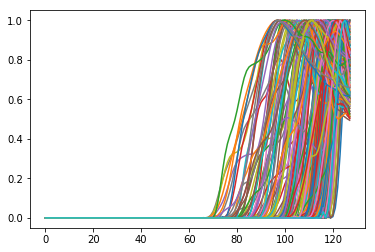

In [5]:
padded_normed_eda_peaks = data_utils.zero_pad_and_normalize_all_peaks(segmented_data,
                                                                     valid_environments=['Spiders'],
                                                                     final_length=128,
                                                                     plot=True)

In [ ]:
# eda_peaks = data_utils.extract_valid_EDA_peaks_from_signal(segmented_data[volunteer][vr_environment], plot=True)
# normed_eda_peaks = data_utils.normalize_peaks(eda_peaks, plot=True)
# padded_normed_eda_peaks = data_utils.zero_pad_peaks(normed_eda_peaks)

In [ ]:
# for peak in padded_normed_eda_peaks:
#     plt.plot(peak)